In [2]:
import os.path

import keras as keras
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Dense, MultiHeadAttention
import keras.backend as K
from keras.models import Sequential
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
datav1 = pd.read_json("C:/51mtech/desertation/data/02.news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json",encoding="utf8",  lines=True)
datav2 = pd.read_json("C:/51mtech/desertation/data/02.news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",encoding="utf8",  lines=True)

In [4]:
all_data = pd.concat([datav1,datav2])
all_data.info()
all_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [5]:
all_data = all_data.drop(columns={'article_link'})
all_data.info()
all_data.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


,headline,is_sarcastic
28609,bakery owner vows to stop making wedding cakes...,0
28610,congressman picked last for committee on youth...,1
28611,grandmother doesn't care for new priest,1
28612,polish rapper under fire for use of the word '...,1
28613,how san antonio's dominant defense is fueling ...,0
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg-gat...,1
28618,dad clarifies this not a food stop,1


In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"i'd", "i should", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"\'s", "", text)
#    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

def strip_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    text = [word.translate(table) for word in text.split()]
    return text

def strip_stopwords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text =  [word for word in text if word not in stopwords]
    return text

def strip_numbers(text):
    words = [word for word in text if word.isalpha()]
    return words

def lemmatize_words(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(i) for i in text]

In [7]:
def preprocess_data(dataframe):
    all_data['clean_text'] = all_data.headline.apply(clean_text)
    all_data['clean_text'] = all_data['clean_text'].apply(lambda x: strip_punctuation(x))
    all_data['clean_text'] = all_data['clean_text'].apply(lambda x: strip_stopwords(x))
    all_data['clean_text'] = all_data['clean_text'].apply(lambda x: strip_numbers(x))
    all_data['clean_text'] = all_data['clean_text'].apply(lambda x: lemmatize_words(x))

preprocess_data(all_data)
all_data[0:10]

,headline,is_sarcastic,clean_text
0,former versace store clerk sues over secret 'b...,0,"[former, versace, store, clerk, sue, secret, b..."
1,the 'roseanne' revival catches up to our thorn...,0,"[roseanne, revival, catch, thorny, political, ..."
2,mom starting to fear son's web series closest ...,1,"[mom, starting, fear, son, web, series, closes..."
3,"boehner just wants wife to listen, not come up...",1,"[boehner, want, wife, listen, come, alternativ..."
4,j.k. rowling wishes snape happy birthday in th...,0,"[jk, rowling, wish, snape, happy, birthday, ma..."
5,advancing the world's women,0,"[advancing, world, woman]"
6,the fascinating case for eating lab-grown meat,0,"[fascinating, case, eating, labgrown, meat]"
7,"this ceo will send your kids to school, if you...",0,"[ceo, send, kid, school, work, company]"
8,top snake handler leaves sinking huckabee camp...,1,"[top, snake, handler, leaf, sinking, huckabee,..."
9,friday's morning email: inside trump's presser...,0,"[friday, morning, email, inside, trump, presse..."


In [8]:
all_data.head(10)

,headline,is_sarcastic,clean_text
0,former versace store clerk sues over secret 'b...,0,"[former, versace, store, clerk, sue, secret, b..."
1,the 'roseanne' revival catches up to our thorn...,0,"[roseanne, revival, catch, thorny, political, ..."
2,mom starting to fear son's web series closest ...,1,"[mom, starting, fear, son, web, series, closes..."
3,"boehner just wants wife to listen, not come up...",1,"[boehner, want, wife, listen, come, alternativ..."
4,j.k. rowling wishes snape happy birthday in th...,0,"[jk, rowling, wish, snape, happy, birthday, ma..."
5,advancing the world's women,0,"[advancing, world, woman]"
6,the fascinating case for eating lab-grown meat,0,"[fascinating, case, eating, labgrown, meat]"
7,"this ceo will send your kids to school, if you...",0,"[ceo, send, kid, school, work, company]"
8,top snake handler leaves sinking huckabee camp...,1,"[top, snake, handler, leaf, sinking, huckabee,..."
9,friday's morning email: inside trump's presser...,0,"[friday, morning, email, inside, trump, presse..."


(-0.5, 999.5, 499.5, -0.5)

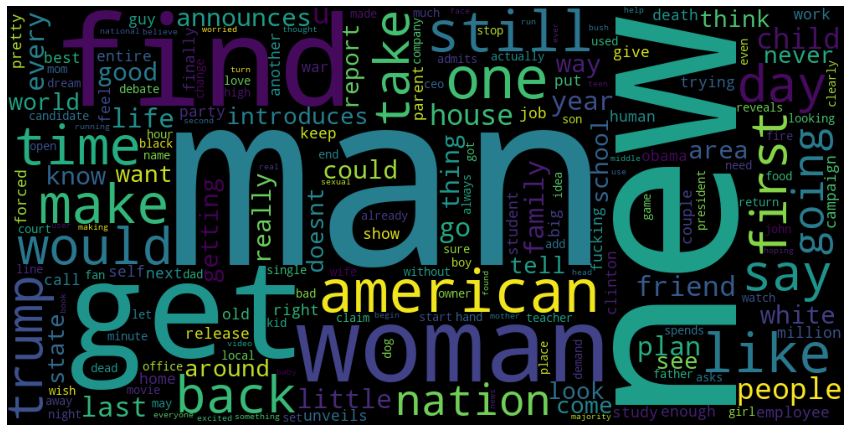

In [9]:
data = all_data.loc[(all_data['is_sarcastic'] == 1),['clean_text']]
data_words = ''
for text in data.clean_text:
  data_words += ','.join(map(str, text))

word_dict = Counter(data_words.split(','))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 999.5, 499.5, -0.5)

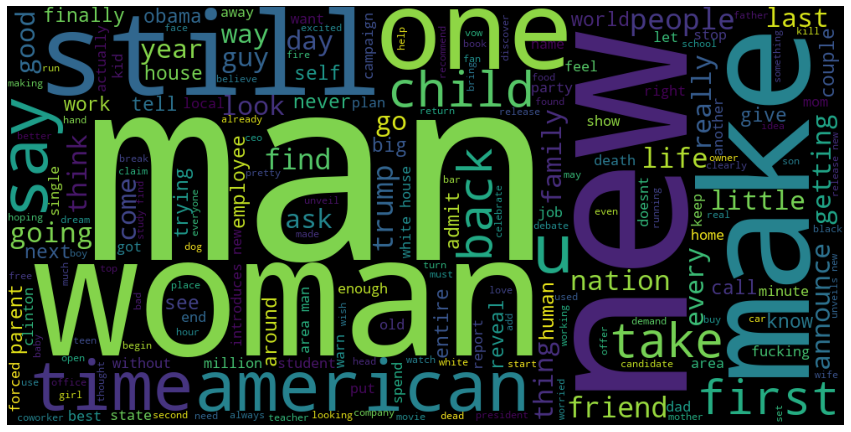

In [10]:
data = all_data.loc[(all_data['is_sarcastic'] == 1),['clean_text']]
data_words = ''
for text in data.clean_text:
  data_words += ','.join(map(str, text))

wordcloud = WordCloud(width = 1000, height = 500).generate(data_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [11]:
# clip the size of the text to 32 rather than taking the whole text

data_split = 0.2
max_length = 32

tokenizer_object = Tokenizer()

tokenizer_object.fit_on_texts(all_data['clean_text'])
#print(tokenizer_object.word_counts)
data_sequences = tokenizer_object.texts_to_sequences(all_data['clean_text'])
#print(sequences)

max_text_length = 0
for i in range(len(data_sequences)):
    if max_text_length <= len(data_sequences[i]):
        max_text_length = len(data_sequences[i])
print('Max length --> ', max_text_length)

word_index = tokenizer_object.word_index
print('Unique Words --> ', len(word_index))

padded_data = pad_sequences(data_sequences, maxlen = max_length, padding='post')
output_data = all_data['is_sarcastic'].values
indices = np.arange(padded_data.shape[0])
np.random.shuffle(indices)
padded_data = padded_data[indices]
output_data = output_data[indices]

num_test_data = int(data_split * padded_data.shape[0])
X_train = padded_data[:-num_test_data]
y_train = output_data[:-num_test_data]
X_test = padded_data[-num_test_data:]
y_test = output_data[-num_test_data:]

Max length -->  106
Unique Words -->  24896


In [12]:
print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 32)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 32)
Shape of y_test: (11065,)


In [13]:
# Load Glove Model

glove_embedding = {}
glove_dimension = 100

GLOVE_DIR = 'C:/05pythonworkspace/glove/twitter'
file = open(os.path.join(GLOVE_DIR,'glove.twitter.27B.100d.txt'),'r',encoding='utf-8')
for line in file:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],dtype='float32')
    glove_embedding[word] = vector
file.close()

print('Found %s word vectors.' % len(glove_embedding))

Found 1193514 word vectors.


In [14]:
embedded_data = np.zeros((len(word_index)+1, glove_dimension))
count = 0
for word, i in word_index.items():
    embedding_vector =glove_embedding.get(word)
    if embedding_vector is not None:
        count+=1
        embedded_data[i] = embedding_vector

print(embedded_data.shape)

(24897, 100)


In [15]:
embedding_layer = Embedding(len(word_index)+1, glove_dimension, weights=[embedded_data], input_length=max_length, trainable=False)

In [34]:
import keras
from keras_multi_head import MultiHead

model = keras.models.Sequential()
model.add(embedding_layer)
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.25))
model.add(MultiHeadAttention(num_heads=4, key_dim=32))
#model.add(MultiHead(LSTM(units=32), layer_num=5, name='Multi-LSTMs'))
model.add(keras.layers.Flatten(name='Flatten'))
#model.add(keras.layers.Dense(units=4, activation='softmax', name='Dense'))
model.add(Dense(1, activation='sigmoid'))
model.build()
model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

TypeError: call() missing 1 required positional argument: 'value'

In [21]:
#training
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test), verbose=2)

Epoch 1/15
1384/1384 - 34s - loss: 0.4936 - acc: 0.7581 - val_loss: 0.4244 - val_acc: 0.8060 - 34s/epoch - 25ms/step
Epoch 2/15
1384/1384 - 25s - loss: 0.3884 - acc: 0.8259 - val_loss: 0.3717 - val_acc: 0.8334 - 25s/epoch - 18ms/step
Epoch 3/15
1384/1384 - 26s - loss: 0.3244 - acc: 0.8604 - val_loss: 0.3447 - val_acc: 0.8502 - 26s/epoch - 19ms/step
Epoch 4/15
1384/1384 - 26s - loss: 0.2661 - acc: 0.8909 - val_loss: 0.3384 - val_acc: 0.8568 - 26s/epoch - 19ms/step
Epoch 5/15
1384/1384 - 26s - loss: 0.2108 - acc: 0.9171 - val_loss: 0.3091 - val_acc: 0.8794 - 26s/epoch - 18ms/step
Epoch 6/15
1384/1384 - 26s - loss: 0.1671 - acc: 0.9374 - val_loss: 0.3043 - val_acc: 0.8854 - 26s/epoch - 19ms/step
Epoch 7/15
1384/1384 - 27s - loss: 0.1301 - acc: 0.9515 - val_loss: 0.2807 - val_acc: 0.9037 - 27s/epoch - 19ms/step
Epoch 8/15
1384/1384 - 28s - loss: 0.0999 - acc: 0.9632 - val_loss: 0.2745 - val_acc: 0.9157 - 28s/epoch - 20ms/step
Epoch 9/15
1384/1384 - 26s - loss: 0.0798 - acc: 0.9715 - val_lo

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()